In [1]:
from spyglass.spikesorting import CuratedSpikeSorting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from spyglass.common import interval_list_contains

import os
os.chdir("/home/sambray/Documents/MS_analysis_samsplaying/")
from ms_opto_stim_protocol import OptoStimProtocol
from Analysis.lfp_analysis import get_ref_electrode_index
from Analysis.utils import (
    filter_animal,
    weighted_quantile,
    filter_task,
    convert_delta_marks_to_timestamp_values,
)

from spyglass.common import convert_epoch_interval_name_to_position_interval_name
from spyglass.position.v1 import TrodesPosV1
from spyglass.lfp.analysis.v1 import LFPBandV1

[2023-11-14 15:41:50,480][INFO]: Connecting sambray@lmf-db.cin.ucsf.edu:3306
[2023-11-14 15:41:50,534][INFO]: Connected sambray@lmf-db.cin.ucsf.edu:3306
/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/spikeinterface/sortingcomponents/peak_detection.py:643: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(parallel=False)
/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/spikeinterface/sortingcomponents/peak_detection.py:668: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to Tru

# Define Data

In [21]:
nwb_file_name = "Winnie20220713_.nwb"

nwb_file_name = "Wallie20220911_.nwb"	
interval_name = "04_lineartrack"
sort_interval_name = interval_name

pos_interval_name = convert_epoch_interval_name_to_position_interval_name({"nwb_file_name":nwb_file_name,
                         "interval_list_name":interval_name})
print(interval_name), print(pos_interval_name)

04_lineartrack
pos 3 valid times


(None, None)

In [16]:
drive_freq = 4
animal="Yoshi"
dataset_key = {'optogenetic_protocol':'pulse_train',
'period_ms':int(1/drive_freq*1000),
'pulses_per_train':1,
"laser_power": 77,
"animal":animal,
"min_pulse_length":25,
"max_pulse_length":42,
# "transfected":True,
}

# sys.path.append("/home/sambray/Documents/MS_analysis_samsplaying/")
os.chdir("/home/sambray/Documents/MS_analysis_samsplaying/")
from ms_opto_stim_protocol import (
    OptoStimProtocol,
    OptoStimProtocolLaser,
    OptoStimProtocolTransfected,
    OptoStimProtocolClosedLoop,
)

dataset_table = OptoStimProtocol
if "transfected" in dataset_key:
    dataset_table = dataset_table * OptoStimProtocolTransfected
if "laser_power" in dataset_key:
    dataset_table = dataset_table * OptoStimProtocolLaser
if "targeted_phase" in dataset_key:
    dataset_table = dataset_table * OptoStimProtocolClosedLoop
dataset = dataset_table & dataset_key
if "animal" in dataset_key:
    dataset = filter_animal(dataset, dataset_key["animal"])
if "track_type" in dataset_key:
    dataset = filter_task(dataset, dataset_key["track_type"])
if "min_pulse_length" in dataset_key:
    dataset = dataset & f"pulse_length_ms>{dataset_key['min_pulse_length']}"
if "max_pulse_length" in dataset_key:
    dataset = dataset & f"pulse_length_ms<{dataset_key['max_pulse_length']}"
print("datasets:", len(dataset))
dataset

nwb_file_name = dataset.fetch("nwb_file_name")[1]
sort_interval_name = dataset.fetch("interval_list_name")[1]
pos_interval_name = sort_interval_name
from spyglass.common import PositionIntervalMap
# PositionIntervalMap & {"nwb_file_name":nwb_file_name,}# "interval_list_name":sort_interval_name}

datasets: 3


In [13]:
sort_interval_name

'pos 3 valid times'

# Get Data

In [30]:
basic_key = {"nwb_file_name":nwb_file_name, "sort_interval_name":sort_interval_name}
pos_key =  {"nwb_file_name":nwb_file_name,"interval_list_name":pos_interval_name}
# f"ms_stim_{dataset_key['period_ms']}ms_period"
band_filter_name = "Theta 5-11 Hz"

restrict_interval = None
restrict_interval_list = [(OptoStimProtocol() & pos_key).fetch1("control_intervals"),
                     (OptoStimProtocol() & pos_key).fetch1("test_intervals"),]


# #spike data
spike_df = []
# cur_id = np.max((CuratedSpikeSorting() & basic_key).fetch("curation_id"))
# for key in (CuratedSpikeSorting() & basic_key& {"curation_id":cur_id}):
#     tetrode_df = ((CuratedSpikeSorting & key).fetch_nwb()[0])
#     if 'units' in tetrode_df:
#         tetrode_df = tetrode_df['units']
#         tetrode_df = tetrode_df[tetrode_df.label == ""]
#         spike_df.append(tetrode_df)
# spike_df = pd.concat(spike_df)
# get the spike and position dat for each

for sort_group in set(
    (CuratedSpikeSorting() & basic_key).fetch("sort_group_id")
):
    key = {"sort_group_id": sort_group}
    cur_id = np.max(
        (CuratedSpikeSorting() & basic_key & key).fetch("curation_id")
    )
    key["curation_id"] = cur_id
    tetrode_df = (CuratedSpikeSorting & basic_key & key).fetch_nwb()[0]
    if "units" in tetrode_df:
        tetrode_df = tetrode_df["units"]
        tetrode_df = tetrode_df[tetrode_df.label == ""]
        spike_df.append(tetrode_df)
spike_df = pd.concat(spike_df)

# position data
pos_df = (TrodesPosV1() & pos_key).fetch1_dataframe()
pos_time = np.asarray(pos_df.index)

# phase data
lfp_key = {"nwb_file_name":nwb_file_name,"target_interval_list_name":pos_interval_name, 'filter_name':band_filter_name}
LFPBandV1() & lfp_key
ref_elect = get_ref_electrode_index(lfp_key)
phase_df = (LFPBandV1() & lfp_key).compute_signal_phase(electrode_list=[ref_elect])
phase_time = np.asarray(phase_df.index)
phase = np.asarray(phase_df.values[:,0])

IndexError: list index out of range

In [31]:
LFPBandV1() & lfp_key

lfp_merge_id,filter_name descriptive name of this filter,filter_sampling_rate sampling rate for this filter,nwb_file_name name of the NWB file,target_interval_list_name descriptive name of this interval list,lfp_band_sampling_rate the sampling rate for this band,analysis_file_name name of the file,interval_list_name descriptive name of this interval list,lfp_band_object_id the NWB object ID for loading this object from the file
dafb5c2c-b290-51eb-c67f-93187ebcb0c6,Theta 5-11 Hz,1000,Wallie20220911_.nwb,pos 3 valid times,100,Wallie20220911_P0NUS6CHM0.nwb,pos 3 valid times lfp band 100Hz,16ef4fdb-1350-41a1-870e-3b179d76c47b


In [6]:
phase_time.shape
phase.shape

(127833,)

# Analyze

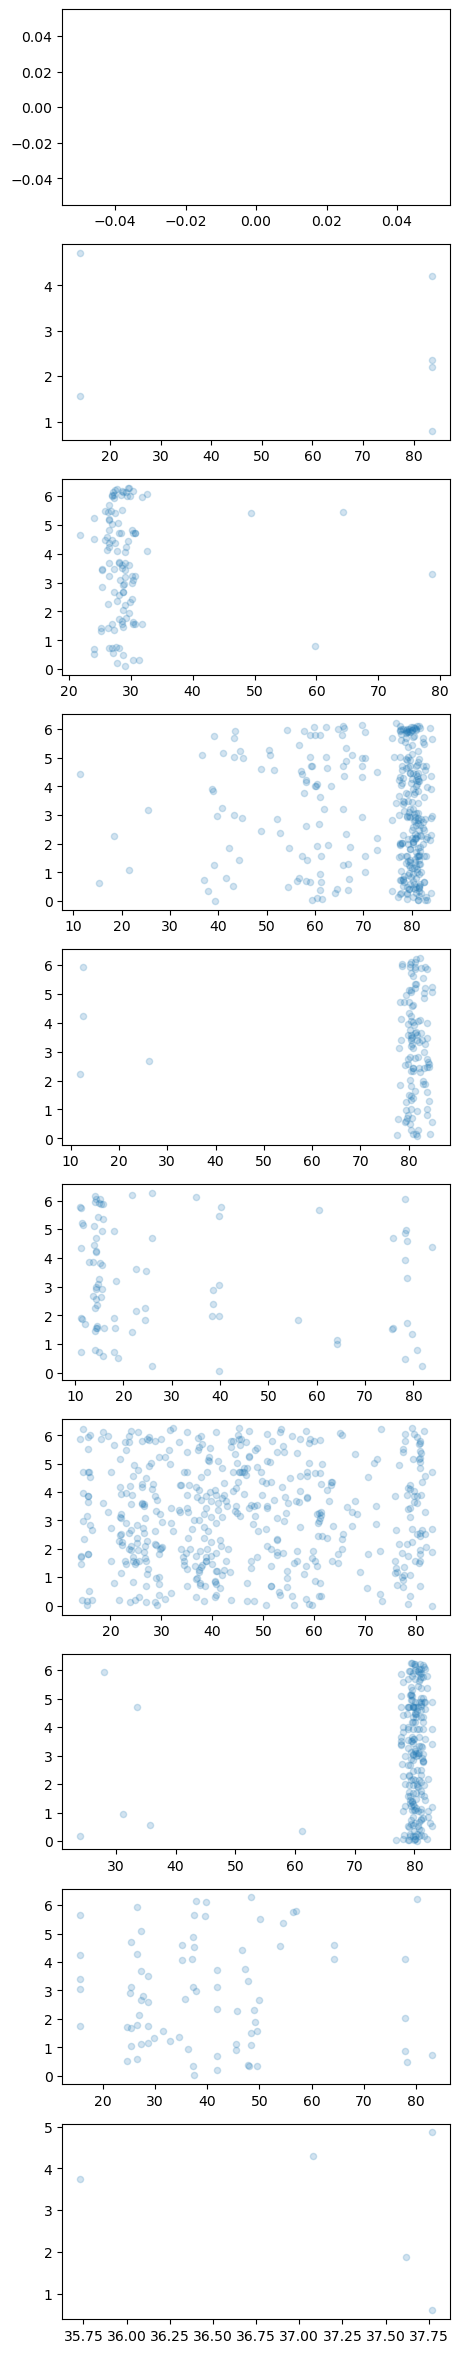

In [28]:
fig,ax = plt.subplots(nrows=10,ncols = 1,sharex=False,figsize=(5,30))
ax = np.ravel(ax)
ax_count = 0

restrict_interval = restrict_interval_list[0]
for spikes in spike_df.spike_times[:]:
    if len(spikes) <100:
        continue
    spikes = interval_list_contains(restrict_interval, spikes)
    if len(spikes) <100:
        continue
    # spikes = interval_list_contains([[np.min(phase_time),np.max(phase_time)]], spikes)
    phase_ind = np.digitize(spikes,phase_time,'left')
    spike_phase = phase[phase_ind]
    spike_ind = np.digitize(spikes, pos_time,)
    spike_pos = pos_df.position_x.iloc[spike_ind].values
    
    right_ind = np.where(pos_df.velocity_x.iloc[spike_ind].values >4)[0]
    # if len(right_ind) < 1000:
    #     continue    
    # plt.scatter(spike_pos[right_ind], spike_phase[right_ind], s=1)
    ax[ax_count].scatter(spike_pos[right_ind], spike_phase[right_ind], alpha = .2,s=20)
    ax_count += 1
    if ax_count>=len(ax):
        break
# 

In [119]:
spikes

array([1.65774906e+09, 1.65774906e+09, 1.65774906e+09, ...,
       1.65775034e+09, 1.65775034e+09, 1.65775034e+09])

In [97]:
16
37
43
44
45
47
48
49
50
65
68
69
72
73
75
94
103
109
110

pos_df


,video_frame_ind,position_x,position_y,orientation,velocity_x,velocity_y,speed
time,,,,,,,
1.657749e+09,8.0,81.45,90.270,0.836716,-1.103367,0.564198,1.239249
1.657749e+09,9.0,81.36,90.315,0.837513,-1.215689,0.669587,1.387893
1.657749e+09,10.0,81.30,90.360,0.838128,-1.228795,0.762501,1.446149
1.657749e+09,11.0,81.18,90.390,0.839027,-1.151104,0.841310,1.425778
1.657749e+09,12.0,81.15,90.360,0.839046,-1.015608,0.898916,1.356285
...,...,...,...,...,...,...,...
1.657750e+09,38534.0,82.89,95.760,0.857314,-2.583076,-0.608288,2.653733
1.657750e+09,38535.0,82.83,95.670,0.857207,-2.215691,-1.032169,2.444312
1.657750e+09,38536.0,82.80,95.580,0.856921,-1.806134,-1.288492,2.218633


In [51]:
phase_time[-1]-phase_time[0]
# spikes.max()-spikes.min()

902.5815761089325

In [69]:
from tqdm import tqdm
spike_pos = []
restrict_interval = restrict_interval_list[0]   
for ii, spikes in tqdm(enumerate(spike_df.spike_times)):
    #find position time bin of each spike
    spikes = interval_list_contains(restrict_interval, spikes)
    
# spike_pos_list.append(spike_pos)

114it [00:00, 2356.36it/s]


In [71]:
LFPBandV1() & lfp_key

lfp_merge_id,filter_name descriptive name of this filter,filter_sampling_rate sampling rate for this filter,nwb_file_name name of the NWB file,target_interval_list_name descriptive name of this interval list,lfp_band_sampling_rate the sampling rate for this band,analysis_file_name name of the file,interval_list_name descriptive name of this interval list,lfp_band_object_id the NWB object ID for loading this object from the file
7a3b6b63-5291-661e-a950-a2e4358f61e5,Theta 5-11 Hz,1000,Winnie20220713_.nwb,pos 3 valid times,100,Winnie20220713_LGD3Y4BRI1.nwb,pos 3 valid times lfp band 100Hz,a3dbe4fe-1d4c-4b5e-b7ba-c091fc73e70d
